# Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [95]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, rcount=200, ccount=200, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [7]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    h,w,N = imarray.shape
    processed_imarray = (imarray.reshape(h*w,N).transpose().reshape(N,h,w) - ambimage).reshape(N,h*w).transpose().reshape(h,w,N)
    processed_imarray = processed_imarray.clip(min = 0)
    processed_imarray = processed_imarray/255.
    return processed_imarray

In [8]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h,w,N = imarray.shape
    V = light_dirs #A.shape = N*3
    I = imarray.reshape(h*w,N).transpose() #B.shape = N*hw
    G = np.linalg.lstsq(V,I)[0]
    G = G.transpose().reshape((h,w,3))
    albedo_image = np.linalg.norm(G,axis = 2)
    surface_normals = G / albedo_image.reshape((h,w,1))
    return albedo_image, surface_normals

In [160]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    numPath = 50.
    h = surface_normals.shape[0]
    w = surface_normals.shape[1]
    fx = np.zeros((h,w))
    fy = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            fx[i][j] = surface_normals[i][j][1]/surface_normals[i][j][2]
            fy[i][j] = surface_normals[i][j][0]/surface_normals[i][j][2]
    fx = np.cumsum(fx, axis = 0)
    fy = np.cumsum(fy, axis = 1)
    if integration_method == 'average':
        height_map = np.zeros((h,w))
        for x in range(h):
            for y in range(w):
                height_map[x][y] = (fx[x][0] + fy[x][y] + fx[x][y] + fy[0][y])/2.
    elif integration_method == 'column':
        height_map = np.zeros((h,w))
        for x in range(h):
            for y in range(w):
                height_map[x][y] = fx[x][0] + fy[x][y]
    elif integration_method == 'row':
        height_map = np.zeros((h,w))
        for x in range(h):
            for y in range(w):
                height_map[x][y] = fx[x][y] + fy[0][y]
    elif integration_method== 'random':
        height_map = np.zeros((h,w))
        for row in range(h):
            for col in range(w):
                height = 0
                for i in range(int(numPath)):
                    height += Random(fx,fy,row,col)
                height /= numPath
                height_map[row][col] = height
    return height_map

def Random(pathDown,pathRight,dstRow,dstCol):
    currRow = 0
    currCol = 0
    retX = pathDown[0][0]
    retY = pathRight[0][0]
    #np.random.randint(low,high)   one int from [low,high)
    while currRow != dstRow or currCol != dstCol:
        stepDown = 0
        stepRight = 0
        if currRow != dstRow:
            stepDown = np.random.randint(1, dstRow-currRow+1)
        if currCol != dstCol:
            stepRight = np.random.randint(1, dstCol-currCol+1)
        if stepDown != 0:
            retX += pathDown[currRow+stepDown][currCol]-pathDown[currRow][currCol]
            currRow += stepDown
        if stepRight != 0:
            retY += pathRight[currRow][currCol+stepRight] - pathRight[currRow][currCol]
            currCol += stepRight
    return retX + retY

# Main function

In [161]:
root_path = '/Users/ziyangliu/Documents/CS543CV/assignment1/assignment1_materials/croppedyale/'#'../croppedyale/'
subject_name = 'yaleB02'
integration_method = 'random'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)

height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

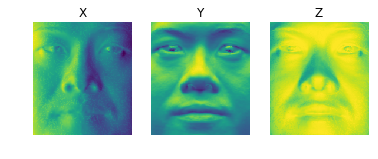

In [162]:
plot_surface_normals(surface_normals)

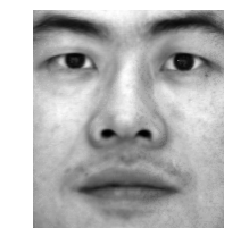

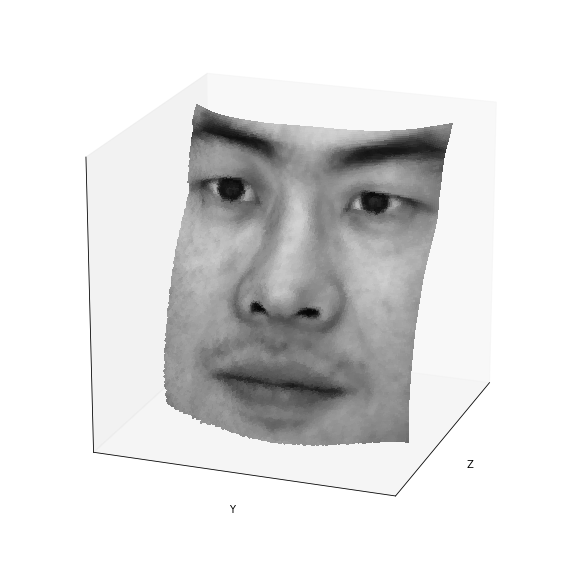

In [163]:
display_output(albedo_image, height_map)